<a href="https://colab.research.google.com/github/dhirajkrgupta/classical-models/blob/main/classicalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score,roc_curve,auc,matthews_corrcoef,cohen_kappa_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# **Step 1: Data Preparation**

In [3]:
import json

data = []
with open("/content/SubtaskA.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        if not line:  # skip empty lines
            continue
        try:
            record = json.loads(line)
            filtered = {k: record[k] for k in ("text", "label") if k in record}
            data.append(filtered)
        except json.JSONDecodeError as e:
            print(f"Error on line {i}: {e}")

df=pd.DataFrame(data)
df.to_csv("/content/subtaskA.csv", index=False)

Error on line 519: Expecting property name enclosed in double quotes: line 1 column 1945 (char 1944)
Error on line 691: Expecting ',' delimiter: line 1 column 3128 (char 3127)
Error on line 3392: Expecting ':' delimiter: line 1 column 3372 (char 3371)
Error on line 3610: Expecting ',' delimiter: line 1 column 1415 (char 1414)
Error on line 4126: Expecting property name enclosed in double quotes: line 1 column 1505 (char 1504)
Error on line 4275: Expecting ',' delimiter: line 1 column 10813 (char 10812)
Error on line 4988: Expecting ':' delimiter: line 1 column 2824 (char 2823)
Error on line 5503: Expecting ',' delimiter: line 1 column 1307 (char 1306)
Error on line 10728: Expecting ':' delimiter: line 1 column 3567 (char 3566)
Error on line 11469: Expecting ',' delimiter: line 1 column 925 (char 924)
Error on line 16748: Expecting property name enclosed in double quotes: line 1 column 4238 (char 4237)
Error on line 16953: Expecting ',' delimiter: line 1 column 1088 (char 1087)
Error on

In [4]:
print(len(df))

296287


# **Step 3: Text Vectorization**


In [5]:
def create_text_features(texts, max_features=5000, ngram_range=(1, 2), vectorizer_type='tfidf'):
    """
    Create text features using different vectorization methods
    """
    # Clean and preprocess texts
    cleaned_texts = []
    for text in texts:
        if text and isinstance(text, str) and not pd.isna(text):
            cleaned_texts.append(str(text).strip())
        else:
            cleaned_texts.append("")

    # Choose vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )

    text_features = vectorizer.fit_transform(cleaned_texts)
    return text_features, vectorizer

# **Step 4: Model Training Pipeline**

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# compute matrix
def plotconfusino_matrix(conf_matrix):
    # define class labels
    classes = ["Human", "AI"]  # change to your own labels

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # tick marks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # put numbers in the cells
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(
                j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


In [7]:
class FlexibleAIHumanClassifier:
    """
    Flexible classifier that can use any sklearn classifier
    """

    def __init__(self, classifier_name='logistic', max_features=3000, ngram_range=(1, 2),
                 vectorizer_type='tfidf', use_scaling=True):

        self.vectorizer = None
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer_type = vectorizer_type
        self.classifier_name = classifier_name

        # Initialize the classifier based on name
        self.model = self._get_classifier(classifier_name)
    def _get_classifier(self, classifier_name):
        """Get classifier by name with optimized parameters"""
        classifiers = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm': LinearSVC( C=1.0,max_iter=1000,tol=1e-3,dual=False,random_state=42),
            'naive_bayes': MultinomialNB(),
            'knn': KNeighborsClassifier(n_neighbors=5),
            'decision_tree': DecisionTreeClassifier(random_state=42),
            'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'lda': LinearDiscriminantAnalysis(),
            'xgboost': XGBClassifier(random_state=42, n_jobs=-1),
            'mlp': MLPClassifier(random_state=42)
        }

        if classifier_name not in classifiers:
            raise ValueError(f"Classifier '{classifier_name}' not supported. Available: {list(classifiers.keys())}")

        return classifiers[classifier_name]

    def prepare_features(self, texts, fit_transform=True):
      if fit_transform:
          text_features, self.vectorizer = create_text_features(
              texts, self.max_features, self.ngram_range, self.vectorizer_type
          )
      else:
          # use the already-fitted vectorizer to just transform new texts
          cleaned_texts = [
              str(t).strip() if t and isinstance(t, str) and not pd.isna(t) else ""
              for t in texts
          ]
          text_features = self.vectorizer.transform(cleaned_texts)

      # Convert sparse to dense if the classifier requires it
      if isinstance(self.model, (GaussianNB, LinearDiscriminantAnalysis)):
          text_features = text_features.toarray()

      return text_features


    def train(self, X_train, y_train):
        """Train the classifier"""
        # Prepare features
        X_train_features = self.prepare_features(X_train, fit_transform=True)
        # Train the model
        self.model.fit(X_train_features, y_train)
        return self

    def predict(self, X_test):
        """Make predictions"""
        # Prepare features
        X_test_features = self.prepare_features(X_test, fit_transform=False)

        # Predict
        predictions = self.model.predict(X_test_features)

        # Get probabilities if available
        try:
            probabilities = self.model.predict_proba(X_test_features)
        except:
            probabilities = None

        return predictions, probabilities

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        predictions, probabilities = self.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions, target_names=['AI', 'Human'])
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        mcc=matthews_corrcoef(y_test, predictions)
        kappa_score=cohen_kappa_score(y_test, predictions)
        conf_matrix = confusion_matrix(y_test, predictions)
        plotconfusino_matrix(conf_matrix)

        # Calculate AUC if probabilities are available
        auc_score = None
        if probabilities is not None:
            auc_score = roc_auc_score(y_test, probabilities[:, 1])
            # Plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc="lower right")
            plt.show()

        return {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'mcc':mcc,
            'cohen_kappa_score':kappa_score,
            'predictions': predictions,
            'probabilities': probabilities
        }

# **Step 6: Usage Example**

In [8]:
def train_single_classifier(classifier_name='random_forest'):
    """
    Train a single classifier
    """
    # Load data
    train_df = pd.read_csv("/content/subtaskA.csv")

    # Handle missing labels
    train_df.dropna(subset=['label'], inplace=True)

    # Split data
    X = train_df['text']
    y = train_df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    \
    # Train classifier
    classifier = FlexibleAIHumanClassifier(classifier_name=classifier_name)
    classifier.train(X_train, y_train)

    # Evaluate
    results = classifier.evaluate(X_test, y_test)

    print(f"Results for {classifier_name}:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    if results['auc_score']:
        print(f"AUC Score: {results['auc_score']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"MCC: {results['mcc']:.4f}")
    print(f"Cohen Kappa Score: {results['cohen_kappa_score']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])

    return classifier, results

**Logistic Regression**

In [9]:
train_df = pd.read_csv("/content/subtaskA.csv")
print(len(train_df))

227816


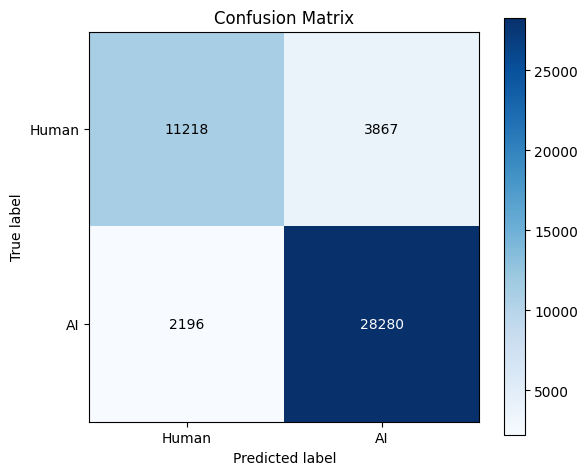

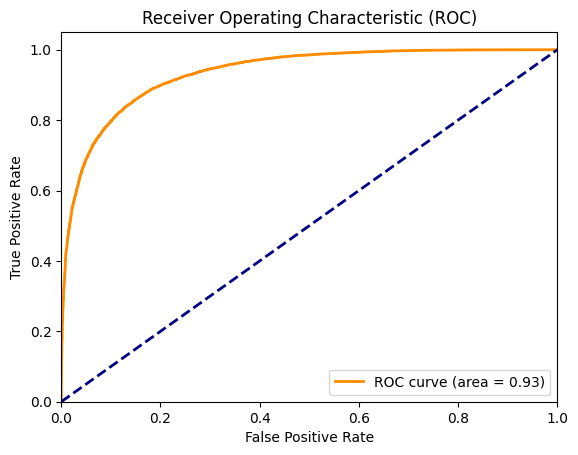

Results for logistic:
Accuracy: 0.8669
AUC Score: 0.9339
Precision: 0.8797
Recall: 0.9279
F1 Score: 0.9032
MCC: 0.6934
Cohen Kappa Score: 0.6909

Classification Report:
              precision    recall  f1-score   support

          AI       0.84      0.74      0.79     15085
       Human       0.88      0.93      0.90     30476

    accuracy                           0.87     45561
   macro avg       0.86      0.84      0.85     45561
weighted avg       0.87      0.87      0.86     45561



In [12]:
logistic,logistic_results= train_single_classifier(classifier_name='logistic');

**MLP**

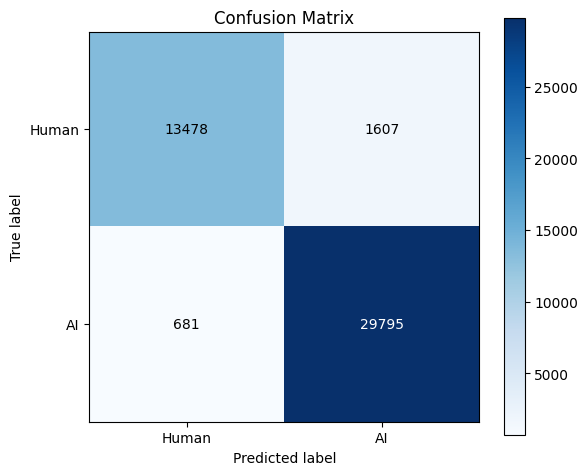

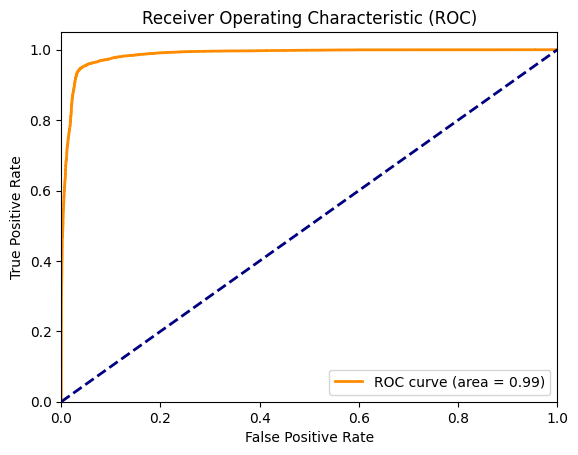

Results for mlp:
Accuracy: 0.9498
AUC Score: 0.9862
Precision: 0.9488
Recall: 0.9777
F1 Score: 0.9630
MCC: 0.8858
Cohen Kappa Score: 0.8848

Classification Report:
              precision    recall  f1-score   support

          AI       0.95      0.89      0.92     15085
       Human       0.95      0.98      0.96     30476

    accuracy                           0.95     45561
   macro avg       0.95      0.94      0.94     45561
weighted avg       0.95      0.95      0.95     45561



In [13]:
mlp,mlp_results= train_single_classifier(classifier_name='mlp');

**Random forest**

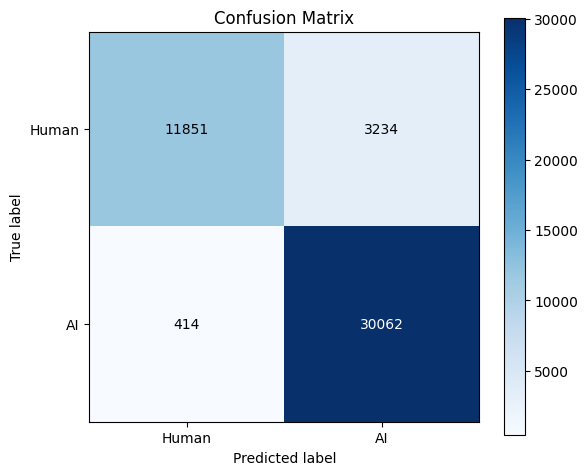

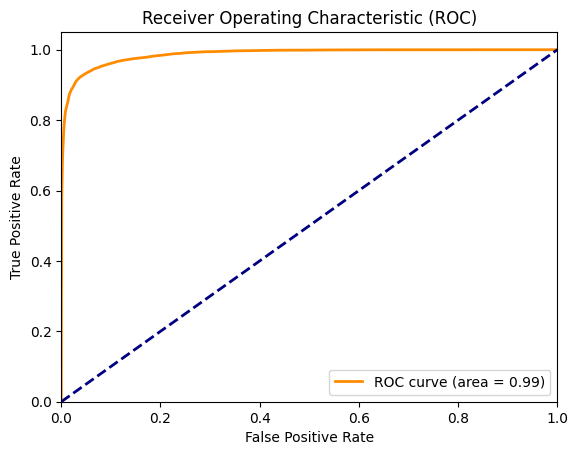

Results for random_forest:
Accuracy: 0.9199
AUC Score: 0.9866
Precision: 0.9029
Recall: 0.9864
F1 Score: 0.9428
MCC: 0.8191
Cohen Kappa Score: 0.8103

Classification Report:
              precision    recall  f1-score   support

          AI       0.97      0.79      0.87     15085
       Human       0.90      0.99      0.94     30476

    accuracy                           0.92     45561
   macro avg       0.93      0.89      0.90     45561
weighted avg       0.92      0.92      0.92     45561



In [14]:
random_forest,random_forest_results= train_single_classifier(classifier_name='random_forest');

**Naive Bayes**

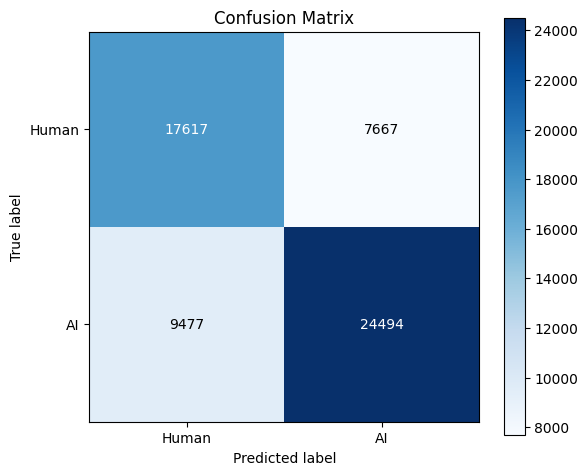

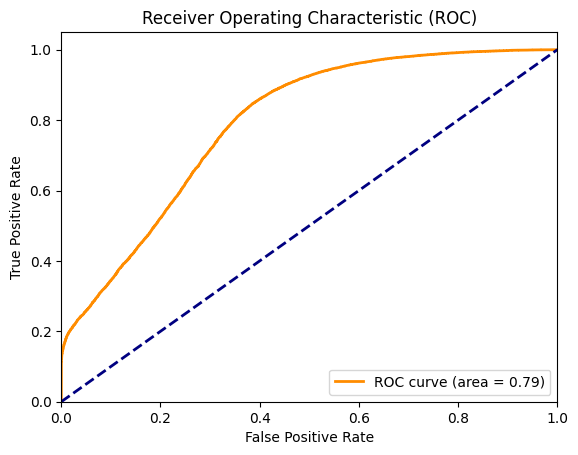

Results for naive_bayes:
Accuracy: 0.7107
AUC Score: 0.7900
Precision: 0.7616
Recall: 0.7210
F1 Score: 0.7408
MCC: 0.4148
Cohen Kappa Score: 0.4140

Classification Report:
              precision    recall  f1-score   support

          AI       0.65      0.70      0.67     25284
       Human       0.76      0.72      0.74     33971

    accuracy                           0.71     59255
   macro avg       0.71      0.71      0.71     59255
weighted avg       0.71      0.71      0.71     59255



In [9]:
naive_bayes,naive_bayes_results= train_single_classifier(classifier_name='naive_bayes')


KNN

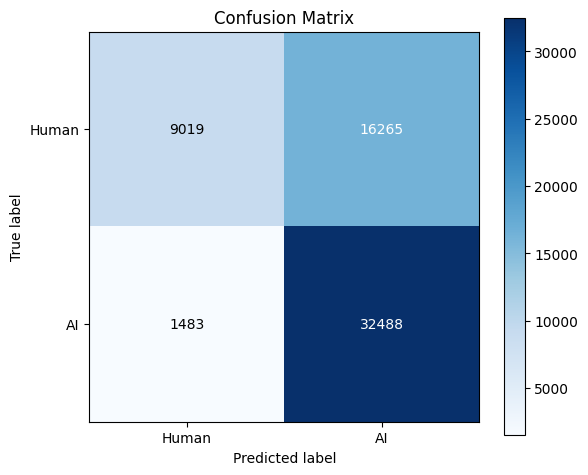

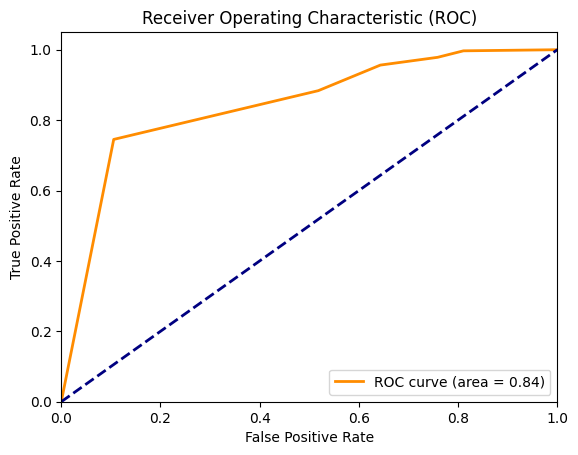

Results for knn:
Accuracy: 0.7005
AUC Score: 0.8424
Precision: 0.6664
Recall: 0.9563
F1 Score: 0.7855
MCC: 0.4055
Cohen Kappa Score: 0.3383

Classification Report:
              precision    recall  f1-score   support

          AI       0.86      0.36      0.50     25284
       Human       0.67      0.96      0.79     33971

    accuracy                           0.70     59255
   macro avg       0.76      0.66      0.64     59255
weighted avg       0.75      0.70      0.67     59255



In [10]:
knn,knn_results= train_single_classifier(classifier_name='knn')


**Decision Tree**

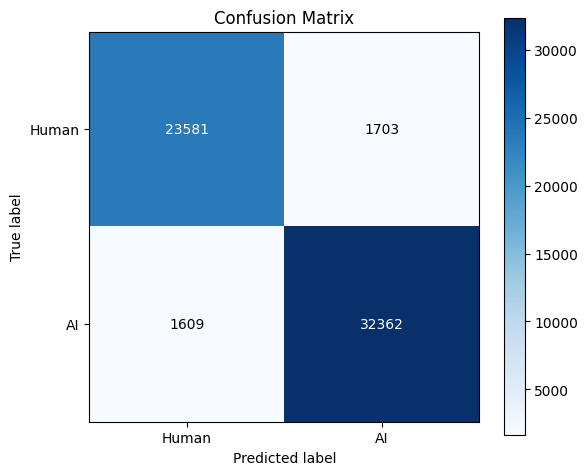

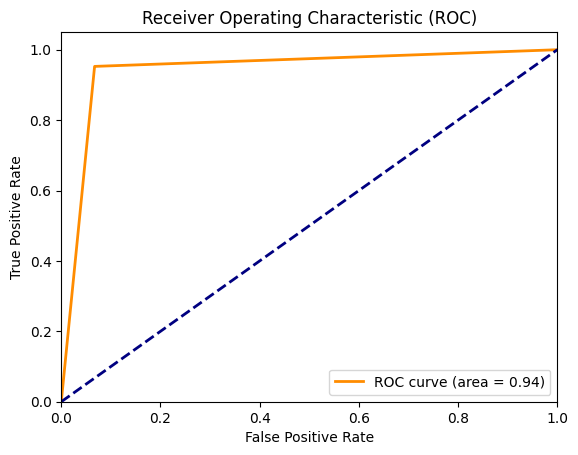

Results for decision_tree:
Accuracy: 0.9441
AUC Score: 0.9427
Precision: 0.9500
Recall: 0.9526
F1 Score: 0.9513
MCC: 0.8857
Cohen Kappa Score: 0.8857

Classification Report:
              precision    recall  f1-score   support

          AI       0.94      0.93      0.93     25284
       Human       0.95      0.95      0.95     33971

    accuracy                           0.94     59255
   macro avg       0.94      0.94      0.94     59255
weighted avg       0.94      0.94      0.94     59255



In [11]:
decision_tree,decision_tree_results= train_single_classifier(classifier_name='decision_tree')


**Extra Trees**

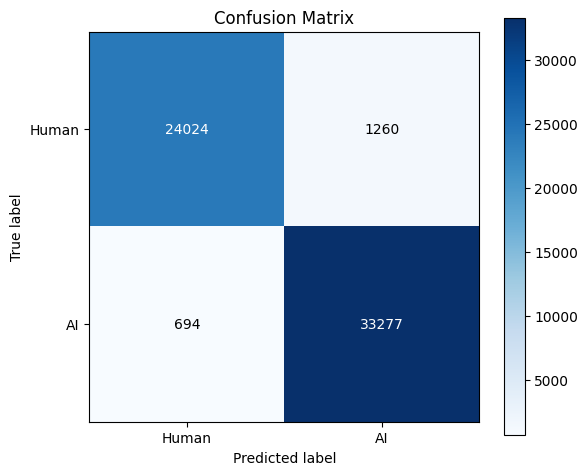

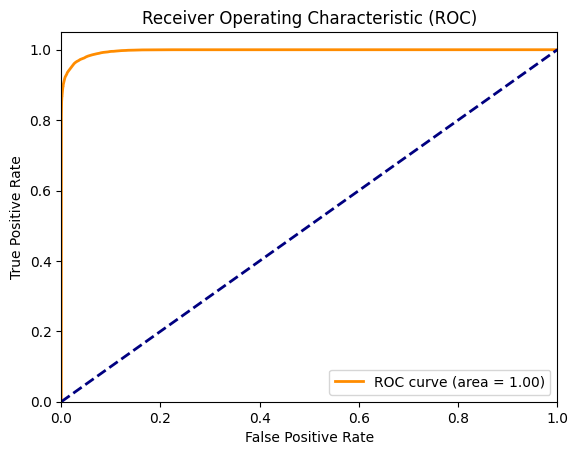

Results for extra_trees:
Accuracy: 0.9670
AUC Score: 0.9967
Precision: 0.9635
Recall: 0.9796
F1 Score: 0.9715
MCC: 0.9326
Cohen Kappa Score: 0.9324

Classification Report:
              precision    recall  f1-score   support

          AI       0.97      0.95      0.96     25284
       Human       0.96      0.98      0.97     33971

    accuracy                           0.97     59255
   macro avg       0.97      0.96      0.97     59255
weighted avg       0.97      0.97      0.97     59255



In [12]:
extra_trees,extra_trees_results= train_single_classifier(classifier_name='extra_trees')

**LDA**

In [ ]:
lda,lda_results= train_single_classifier(classifier_name='lda')


**xgboost**

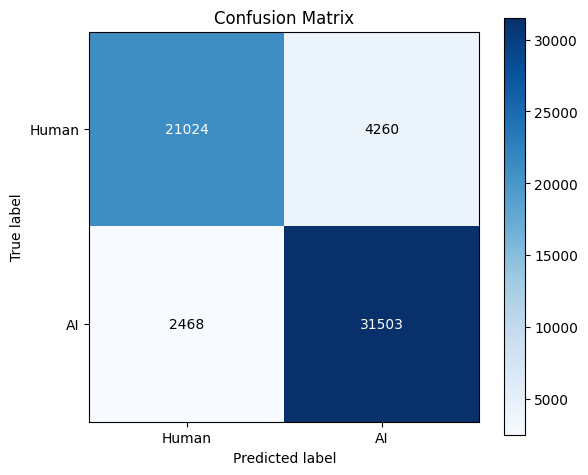

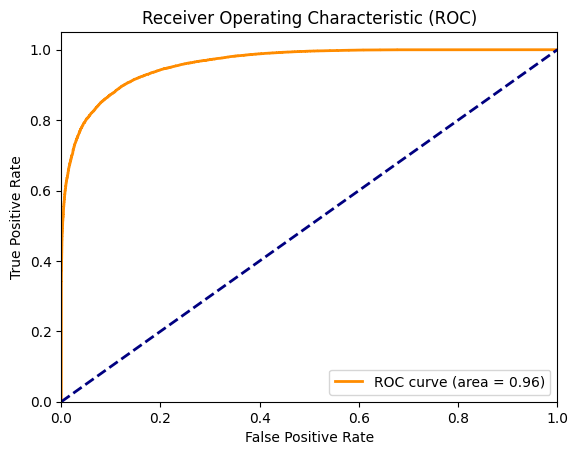

Results for xgboost:
Accuracy: 0.8865
AUC Score: 0.9610
Precision: 0.8809
Recall: 0.9273
F1 Score: 0.9035
MCC: 0.7673
Cohen Kappa Score: 0.7658

Classification Report:
              precision    recall  f1-score   support

          AI       0.89      0.83      0.86     25284
       Human       0.88      0.93      0.90     33971

    accuracy                           0.89     59255
   macro avg       0.89      0.88      0.88     59255
weighted avg       0.89      0.89      0.89     59255



In [9]:
xgboost,xgboost_results= train_single_classifier(classifier_name='xgboost')


***SVM***

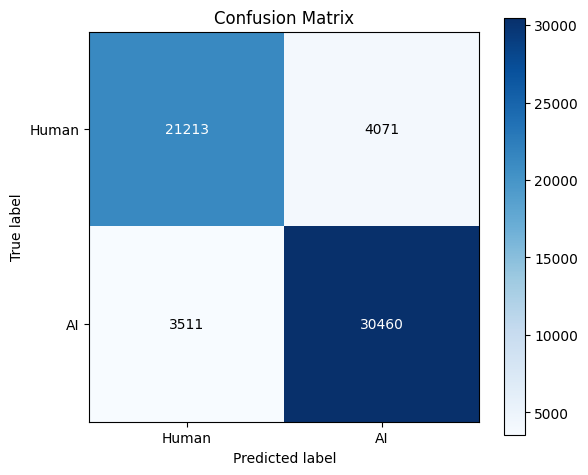

Results for svm:
Accuracy: 0.8720
Precision: 0.8821
Recall: 0.8966
F1 Score: 0.8893
MCC: 0.7379
Cohen Kappa Score: 0.7377

Classification Report:
              precision    recall  f1-score   support

          AI       0.86      0.84      0.85     25284
       Human       0.88      0.90      0.89     33971

    accuracy                           0.87     59255
   macro avg       0.87      0.87      0.87     59255
weighted avg       0.87      0.87      0.87     59255



In [10]:
svm,svm_results= train_single_classifier(classifier_name='svm')